In [1]:
import torch
import math
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt','r').read().splitlines()
len(words)

32033

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {v:k+1 for k,v in enumerate(chars)}
stoi['.'] = 0
itos = {v:k for k, v in stoi.items()}

In [4]:
def build_dataset(words, block_size):
    ''' block size  = number of previous chars to predict next char '''
    context = []
    X , Y = [], []
    for w in words :
        context = [0]* block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape) 
    return X, Y


In [5]:
# train, dev, test splits - 80%, 10%, 10%
random.seed(42)
random.shuffle(words)
block_size = 3
training_len = int(len(words)*0.8)
dev_len = int(len(words)*0.9)

X_tr , Y_tr = build_dataset(words[:training_len] , block_size)
X_d , Y_d = build_dataset(words[training_len : dev_len] , block_size)
X_t , Y_t = build_dataset(words[dev_len :] , block_size)


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


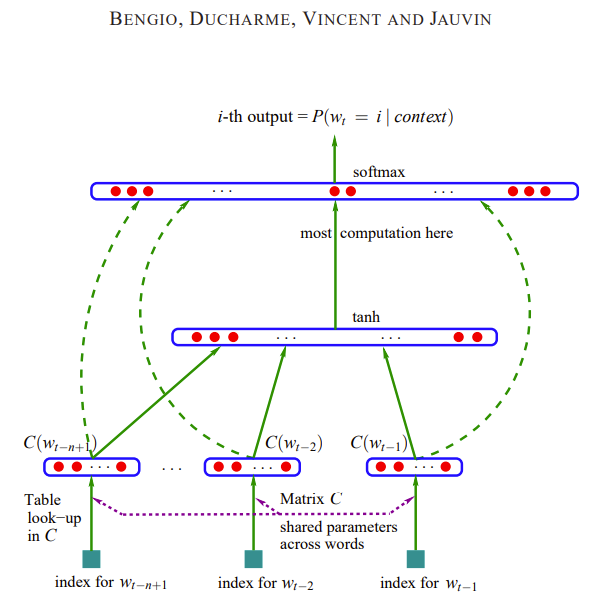

In [53]:
from IPython.display import Image, display
display(Image(filename='mlp.png'))

# ref paper: https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [55]:
# matrix C of embeddings initalized randomly at the start

# we have 27 chars so let's start with 2D space 
C = torch.randn((27,2))  # each one of 27 char will have 2D embedding

first layer of nn - linear neurons with weight matrix C

In [ ]:
# the first piece of emedding integers (inputs) by indexing into lookup table

#example
print(C[5])

print(F.one_hot(torch.tensor(5),num_classes = 27).float() @ C)

# both are equal - either index or encode and feed it in NN
# we will index as its faster and use the embedding matrix C

tensor([-0.0825,  0.7979])
tensor([-0.0825,  0.7979])


In [62]:
X_tr

tensor([[ 0,  0,  0],
        [ 0,  0, 14],
        [ 0, 14, 25],
        ...,
        [14, 13,  1],
        [13,  1, 18],
        [ 1, 18,  9]])

In [ ]:
# pytorch indexing examples

print(C[5]) # indexing with a element

print(C[[5,6,7]]) # indexing with list

print(C[torch.tensor([5,6,7])]) # index with a 1D integer tensor

print(C[torch.tensor([5,6,7,7,7])]) # repeat a row

print(C[X_tr]) # index with a multi dimension integer tensor : 2D in this example

print(C[X_tr].shape) # [182424, 3, 2] : 182424, 3 is the og shape of X_tr and for each of them a 2D embedding is retrieved

tensor([-0.0825,  0.7979])
tensor([[-0.0825,  0.7979],
        [-2.2553, -0.7227],
        [-1.8535, -0.5753]])
tensor([[-0.0825,  0.7979],
        [-2.2553, -0.7227],
        [-1.8535, -0.5753]])
tensor([[-0.0825,  0.7979],
        [-2.2553, -0.7227],
        [-1.8535, -0.5753],
        [-1.8535, -0.5753],
        [-1.8535, -0.5753]])
tensor([[[ 1.5095,  0.6242],
         [ 1.5095,  0.6242],
         [ 1.5095,  0.6242]],

        [[ 1.5095,  0.6242],
         [ 1.5095,  0.6242],
         [ 0.5426, -0.4476]],

        [[ 1.5095,  0.6242],
         [ 0.5426, -0.4476],
         [-0.3863,  1.9230]],

        ...,

        [[ 0.5426, -0.4476],
         [ 0.7375, -0.5062],
         [-0.1642,  0.1446]],

        [[ 0.7375, -0.5062],
         [-0.1642,  0.1446],
         [ 0.9246, -0.9598]],

        [[-0.1642,  0.1446],
         [ 0.9246, -0.9598],
         [ 0.0633, -0.7323]]])
torch.Size([182424, 3, 2])


hidden layer

In [ ]:
emb = C[X_tr]
print(emb.shape)

# now construct hidden layer : emb @ W + b

# number of inputs to this layer would be 6 - 2D embeddings for each of the 3 inputs in the first layer
W1 = torch.randn((6, 100))  # let's keep number of output neurons as 100 for now, upto us
b1 = torch.randn(100)

# emb.view(-1,6)  # same can be done using cat and unbind but this is more efficient as no new memory is created


torch.Size([182424, 3, 2])


In [66]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
h

tensor([[-0.6815,  0.9951,  0.9409,  ..., -0.9989, -0.9980, -0.9654],
        [ 0.4692,  0.9897,  0.9988,  ..., -0.9976, -0.9998, -0.1336],
        [-0.9979,  0.6241,  0.6453,  ..., -0.5634,  0.9593,  0.0125],
        ...,
        [-0.6481,  0.9689,  0.4956,  ...,  0.8933, -0.6698, -0.7027],
        [ 0.1382,  0.9999,  0.7193,  ..., -0.2141, -0.9945, -0.9960],
        [ 0.5127,  0.4826, -0.7183,  ...,  0.7464, -0.9977,  0.0649]])

In [67]:
h.shape

torch.Size([182424, 100])

final layer

In [68]:
W2 = torch.randn((100,27))  # 100 inputs from prev layer and 27 outputs as char
b2 = 27 

logits = h @ W2 + b2
print(logits.shape)
counts  = logits.exp()
probs = counts/counts.sum(1, keepdims=True)

nll = -probs[torch.arange(len(Y_tr)),Y_tr].log().mean()
print(nll)

torch.Size([182424, 27])
tensor(16.5240)


better represented

In [132]:
# all the parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27 , 2),generator=g)  # 27 chars embedded in 2D
W1 = torch.randn((6, 100), generator=g) # 6 (3*2 2D emb from each 3 inputs of prev layer) and 100 output
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g) # 100 from prev layer and 27 output for this layer
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters) # total number of parameters

3481

In [ ]:
logits = h @ W2 + b2
print(logits.shape)
# counts  = logits.exp()
# probs = counts/counts.sum(1, keepdims=True)
# print(-probs[torch.arange(len(Y_tr)),Y_tr].log().mean())
nll = F.cross_entropy(logits, Y_tr)
print(nll)

# '--------------------------------------------------------------'
# reasoning : cross_entropy instead of the manual way
logits = torch.tensor([-1, 1,2,100])
counts  = logits.exp()
probs = counts/counts.sum()
print(probs)

# larger +ve numbers results in inf so cross_entropy is to be used instead of using the manual apprach as in this cell
# torch will internally subtract the max element from each of the element so it is handled well
# forward pass, backward pass are efficient, and things are much more numerically well behaved
logits = torch.tensor([-1, 1,2,100]) - 100
counts  = logits.exp()
probs = counts/counts.sum()
print(probs)

torch.Size([182424, 27])
tensor(16.8113)


In [133]:
for p in parameters:
    p.requires_grad = True

In [ ]:
#training the nn
# complete 2.56 in 5 mins minibatch 2.7 in 1.2s
for i in range(1000):
    # minibatch construct
    ix = torch.randint(0, X_tr.shape[0], (32,))  # picking 32 random samples from X_tr to make this faster

    # forward pass
    emb = C[X_tr[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_tr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # update
    for p in parameters:
        p.data += -0.1 * p.grad 
print(loss)

tensor(2.7180, grad_fn=<NllLossBackward0>)


How to determine a reasonable learning rate?
1. try different rate and observe loss like at -0.0001, -0.001, -0.1, -1, 10
2. pick a range, create some samples between this range
3. plot and check

In [126]:
# torch.linspace(0.001, 1, 1000)
lre  = torch.linspace(-3, 0 , 1000)
lrs = 10 ** lre 

In [ ]:
#training the nn
lri = []
lossi = []
lrel = []
for i in range(1000):
    # minibatch construct
    ix = torch.randint(0, X_tr.shape[0], (32,))  # picking 32 random samples from X_tr to make this faster

    # forward pass
    emb = C[X_tr[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_tr[ix])
    print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    lri.append(lr)
    lrel.append(lre[i]) # appending exponent at i
    lossi.append(loss.item())


# -0.0001 : slow
# -0.001 : is decreasing
# -1 : big
# -10 : way too big, loss isn't decreasing


20.1560001373291
19.406200408935547
19.538406372070312
18.264245986938477
21.098588943481445
19.356792449951172
19.308128356933594
19.714048385620117
18.465063095092773
21.105274200439453
19.063823699951172
17.80686378479004
14.834559440612793
21.18766212463379
18.158489227294922
20.296283721923828
21.404991149902344
15.63332748413086
20.693145751953125
18.433147430419922
18.347713470458984
21.335844039916992
17.967557907104492
19.62824058532715
21.14619255065918
18.89840316772461
19.470272064208984
19.09733772277832
17.77389907836914
18.563701629638672
17.272098541259766
16.91122817993164
20.18414878845215
16.204181671142578
17.901660919189453
21.351882934570312
17.872501373291016
20.65414810180664
16.27638816833496
18.02332878112793
17.49886131286621
19.5374698638916
18.469348907470703
17.85243034362793
16.673828125
20.758752822875977
17.792001724243164
18.005035400390625
16.53829002380371
15.69682502746582
14.947249412536621
16.677326202392578
19.437763214111328
17.931249618530273
1

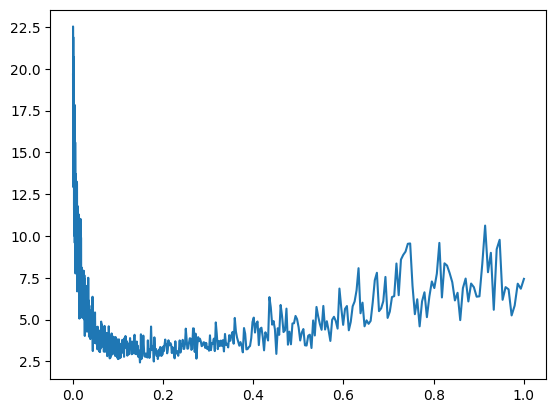

In [122]:
plt.plot(lri,lossi)

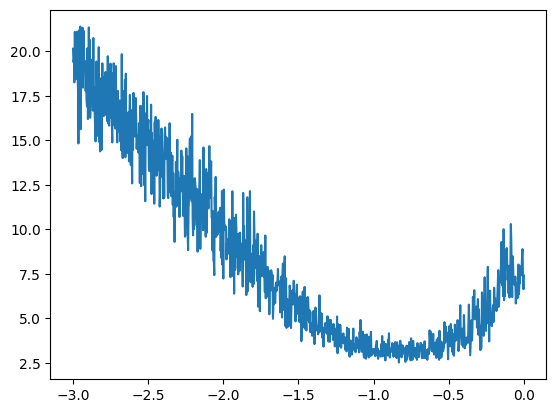

In [128]:
plt.plot(lrel,lossi)

In [142]:
# as per the plot -1.0 as the exponent is a good value so 10**-1 = 0.1 is a good lr

# run this twice/thrice and observe the loss and then decay the lr near the end of training

for i in range(10000):
    # minibatch construct
    ix = torch.randint(0, X_tr.shape[0], (32,))  # picking 32 random samples from X_tr to make this faster

    # forward pass
    emb = C[X_tr[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_tr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # update
    # lr = 0.1
    lr = 0.01  # lr decay
    for p in parameters:
        p.data += -lr * p.grad

print(loss.item())

2.354646682739258


In [144]:
# check on all of training set
emb = C[X_tr]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_tr)
print(loss)

# 2.33 with decay 

tensor(2.3367, grad_fn=<NllLossBackward0>)


In [ ]:
# check on dev
emb = C[X_d]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_d)
print(loss)

# 2.35 

tensor(2.3516, grad_fn=<NllLossBackward0>)


possible bottlenecks -
model size
embeddings being 2D
mini batch szie

# increase the model size

In [148]:
# increase model size
# all the parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27 , 2),generator=g)  # 27 chars embedded in 2D
W1 = torch.randn((6, 300), generator=g) # 6 (3*2 2D emb from each 3 inputs of prev layer) and 300 output
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g) # 300 from prev layer and 27 output for this layer
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [163]:
#training the nn
lossi = []
step = []
for i in range(3000):
    # minibatch construct
    ix = torch.randint(0, X_tr.shape[0], (32,))  # picking 32 random samples from X_tr to make this faster

    # forward pass
    emb = C[X_tr[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_tr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    lossi.append(loss.item())
    step.append(i)

print(loss.item())

# check on all of training set
emb = C[X_tr]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_tr)
print('train: ', loss)

# check on dev
emb = C[X_d]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_d)
print('dev: ', loss)

1.8989298343658447
train:  tensor(2.3100, grad_fn=<NllLossBackward0>)
dev:  tensor(2.3201, grad_fn=<NllLossBackward0>)


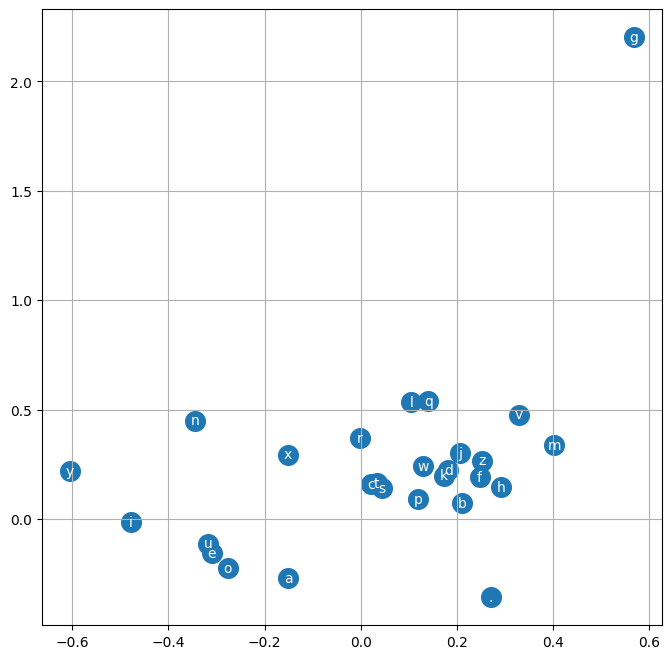

In [164]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

# make the embeddings bigger

In [171]:
# increase the embedding dimension and decrease the size of hidden layer
# all the parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27 , 10),generator=g)  # 27 chars embedded in 2D
W1 = torch.randn((30, 200), generator=g) # 6 (3*2 2D emb from each 3 inputs of prev layer) and 200 output
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g) # 200 from prev layer and 27 output for this layer
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [172]:
sum(p.nelement() for p in parameters) # total number of parameters

11897

In [173]:
lossi = []
step = []
lri = []

In [174]:
#training the nn
for i in range(200000):
    # minibatch construct
    ix = torch.randint(0, X_tr.shape[0], (32,))  # picking 32 random samples from X_tr to make this faster

    # forward pass
    emb = C[X_tr[ix]]
    h = torch.tanh(emb.view(-1,30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_tr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01  # decay in end
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    lossi.append(loss.log10().item())
    step.append(i)

print(loss.item())

# check on all of training set
emb = C[X_tr]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_tr)
print('train: ', loss)

# check on dev
emb = C[X_d]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_d)
print('dev: ', loss)

2.072484016418457
train:  tensor(2.1088, grad_fn=<NllLossBackward0>)
dev:  tensor(2.1681, grad_fn=<NllLossBackward0>)


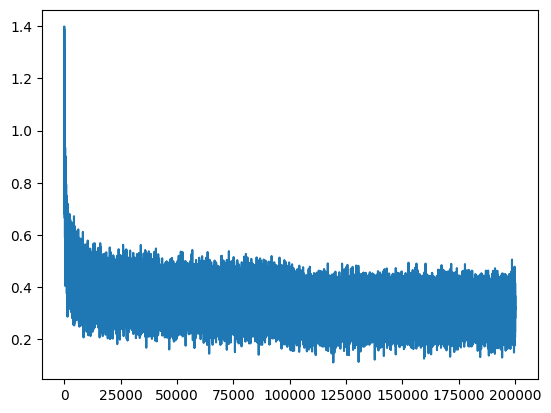

In [175]:
plt.plot(step, lossi)

Sampling

In [179]:
# sample from model
g = torch.Generator().manual_seed(2147483647)

for i in range(20):
    out = ''
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim =1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        context = context[1:] + [ix]
        out += itos[ix]
        if ix==0:
            break
    print(out) 
    

dex.
maleah.
makilah.
tah.
mellissana.
nylandrika.
darreen.
publessi.
gotal.
moriella.
kinzored.
akariyah.
sadel.
akavirny.
fobseihlynn.
bron.
las.
dashra.
antil.
pyan.


check exp lr stuff, log10 loss in lossi, sampling

mixture of models, skip connection

In [67]:
# increase the embedding dimension and decrease the size of hidden layer
# all the parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27 , 15),generator=g)  * 0.01   # 27 chars embedded in 2D
W1 = torch.randn((45, 200), generator=g) * 0.01 # 45 (3*15 2D emb from each 3 inputs of prev layer) and 200 output
# b1 = torch.randn(200, generator=g)
b1 = torch.zeros(200)
W2 = torch.randn((200, 27), generator=g) * 0.01 # 200 from prev layer and 27 output for this layer
# b2 = torch.randn(27, generator=g)
b2 = torch.zeros(27)
# W3 = torch.randn((45, 27), generator=g)  # Weights for a skip connection
parameters = [C, W1, b1, W2, b2]


for p in parameters:
    p.requires_grad = True

In [68]:
sum(p.nelement() for p in parameters) # total number of parameters

15032

In [69]:
lossi = []
step = []
lri = []

In [70]:
#training the nn
for i in range(200000):
    # minibatch construct
    ix = torch.randint(0, X_tr.shape[0], (32,))  # picking 32 random samples from X_tr to make this faster

    # forward pass
    emb = C[X_tr[ix]]
    h = torch.tanh(emb.view(-1,45) @ W1 + b1)
    # skip = emb.view(-1,45) @ W3     
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Y_tr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01  # decay in end
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    lossi.append(loss.log10().item())
    step.append(i)

print(loss.item())

# check on all of training set
emb = C[X_tr]
h = torch.tanh(emb.view(-1,45) @ W1 + b1)
# skip = emb.view(-1,45) @ W3 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Y_tr)
print('train: ', loss)

# check on dev
emb = C[X_d]
h = torch.tanh(emb.view(-1,45) @ W1 + b1)
# skip = emb.view(-1,45) @ W3 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Y_d)
print('dev: ', loss)


# 2.010228157043457
# train:  tensor(2.1290, grad_fn=<NllLossBackward0>)
# dev:  tensor(2.1569, grad_fn=<NllLossBackward0>)

# 1.8631691932678223
# train:  tensor(2.0921, grad_fn=<NllLossBackward0>)
# dev:  tensor(2.1393, grad_fn=<NllLossBackward0>)

# 2.2544338703155518
# train:  tensor(2.0632, grad_fn=<NllLossBackward0>)
# dev:  tensor(2.1282, grad_fn=<NllLossBackward0>)

# 2.1060547828674316
# train:  tensor(2.0851, grad_fn=<NllLossBackward0>)
# dev:  tensor(2.1405, grad_fn=<NllLossBackward0>)

# 1.9968117475509644
# train:  tensor(2.0606, grad_fn=<NllLossBackward0>)
# dev:  tensor(2.1334, grad_fn=<NllLossBackward0>)

1.889456033706665
train:  tensor(2.0808, grad_fn=<NllLossBackward0>)
dev:  tensor(2.1222, grad_fn=<NllLossBackward0>)


In [71]:
# check on test
emb = C[X_t]
h = torch.tanh(emb.view(-1,45) @ W1 + b1)
# skip = emb.view(-1,45) @ W3 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Y_t)
print('test: ', loss)

test:  tensor(2.1198, grad_fn=<NllLossBackward0>)


In [72]:
# sample from model
g = torch.Generator().manual_seed(2147483647)

for i in range(20):
    out = ''
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim =1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        context = context[1:] + [ix]
        out += itos[ix]
        if ix==0:
            break
    print(out) 
    

cer.
mariah.
makima.
kayden.
mairitta.
noluwan.
katar.
samiyah.
javer.
gothi.
moriellah.
jacored.
jen.
emiless.
suhakavion.
ryslspericing.
viah.
asu.
dedric.
neil.
